# Домашняя работа №6 - Методы оптмизации в машинном обучении

**Студент:** Феоктистов Владислав Сергеевич

**Группа:** НПМбд-01-19б

## Подготовительная часть

Для начала импортируем необходимые библиотеки, в том числе написанные в процессе выполнения домашней работы.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

import oracles
import optimization
import presubmit_tests as pt
import plot_trajectory_2d as plt2d

Проверим правильность выведенных аналитически формул для нахождения градиента и матрицы Гесса функции ошибки $E$, сравнивая результаты в конкретной точке с результатами численнымх методов нахождения градиента и матрицы Гесса функции ошибки $E$ в этой же точке (реализация функции есть в oracles в классе *LogRegL2Oracle*).

In [2]:
A = np.array([[1, 2], [-4, 3], [5, 7]])
b = np.array([1, -1, 1])
regcoef = 1.1
oracle = oracles.create_log_reg_oracle(A, b, regcoef, oracle_type='usual')
func = lambda x: oracle.func(x)
x = np.array([2, 3])
print('Градиент аналитически:', oracle.grad(x))
print('Градиент численно:', oracles.grad_finite_diff(func, x))
print('Матрица Гесса аналитически:\n', oracle.hess(x))
print('Матрица Гесса численно:\n', oracles.hess_finite_diff(func, x))

Градиент аналитически: [1.22514345 4.03083501]
Градиент численно: [1.22514345 4.03083513]
Матрица Гесса аналитически:
 [[ 2.14870872 -0.78622424]
 [-0.78622424  1.69028278]]
Матрица Гесса численно:
 [[ 2.14873452 -0.7862333 ]
 [-0.7862333   1.69027459]]


Проверим работу градиентного спуска для квадратичной функции $f(x) = \frac{1}{2} x^TAx - b^Tx$ с единичной матрицей $A = I$, $dim(A) = 5$; вектором $b^T=(0, 1, 2, 3, 4)$ и условием Армихо с константой $c_1 = 10^{-4}$ для адаптивного подбора шага $\alpha$, начиная движение от точки $(0, 0, 0, 0, 0)$. Глобальный минимум такой функции достигается в точке $(0, 1, 2, 3, 4)$.

Пример взят из комментария к функции *gradient_descent* из файла *optinization*.

In [3]:
oracle = oracles.QuadraticOracle(np.eye(5), np.arange(5))
x_opt, message, history = optimization.gradient_descent(oracle, np.zeros(5),
                                                        line_search_options={'method': 'Armijo', 'c1': 1e-4},
                                                        trace=True)
print('Found optimal point: {}'.format(x_opt))

Found optimal point: [0. 1. 2. 3. 4.]


Проверим работу метода Ньютона для той же квадратичной функции с той же матрицей $A$, вектором $b$ и начальной точкой, но с константным шагом $c = 1$. Глобальный минимум, очевидно, должен быть тот же.

Пример взят из комментария к функции *newton* из файла *optinization*.

In [4]:
oracle = oracles.QuadraticOracle(np.eye(5), np.arange(5))
x_opt, message, history = optimization.newton(oracle, np.zeros(5),
                                              line_search_options={'method': 'Constant', 'c': 1.0})
print('Found optimal point: {}'.format(x_opt))

Found optimal point: [0. 1. 2. 3. 4.]


Проверим работу всех функций oracles и optimization с помощью тестов. Как видно ниже, все тесты были успешно пройдены.

In [3]:
pt.test_python3()
pt.test_QuadraticOracle()
pt.test_log_reg_usual()
pt.test_log_reg_oracle_calls()
pt.test_grad_finite_diff_1()
pt.test_grad_finite_diff_2()
pt.test_hess_finite_diff_1()
pt.test_hess_finite_diff_2()
pt.test_line_search()
pt.test_gd_basic()
pt.test_newton_basic()
pt.test_newton_1d()
pt.test_newton_fail()

All OK!
All OK!
All OK!
All OK!


Проверим работу функции *plot_levels* для рисования линий уровня и функции *plot_trajectory* из файла *plot_trajectory_2d.py* для рисования траекторий.

В качестве примера взята квадратичная функция из комментария к функции *plot_trajectory* из файла *plot_trajectory_2d*. 

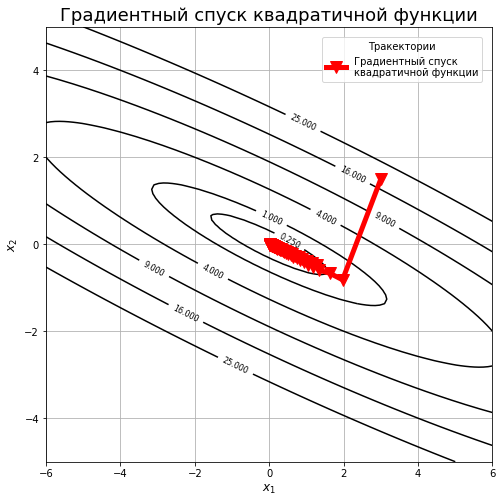

In [10]:
oracle = oracles.QuadraticOracle(np.array([[1.0, 2.0], [2.0, 5.0]]), np.zeros(2))
[x_star, msg, history] = optimization.gradient_descent(oracle, np.array([3.0, 1.5]), trace=True)
fig, ax = plt2d.plot_levels(oracle.func, figsize=(8, 8))
fig, ax = plt2d.plot_trajectory(func=oracle.func, 
                                history=history['x'], 
                                fig_ax = (fig, ax), 
                                label='Градиентный спуск\nквадратичной функции')
ax.set_title('Градиентный спуск квадратичной функции', fontsize = 18)
ax.set_xlabel('$x_1$', fontsize = 12)
ax.set_ylabel('$x_2$', fontsize = 12)
fig.legend(title='Тракектории', loc='center left', bbox_to_anchor=(0.55, 0.77))

Напишем функцию для нахождения числа обусловленности

In [11]:
def conditionality_number(A):
    return np.linalg.norm(A) * np.linalg.norm(np.linalg.inv(A))

## Эксперимент: Траектория градиентного спуска на квадратичной функции.

Проанализируем траекторию градиентного спуска для нескольких квадратичных функций $f(x) = \frac{1}{2} x^TAx - b^Tx$:
1. $A = \begin{pmatrix}
            1.0 & 2.0\\
            2.0 & 5.0
        \end{pmatrix}, 
    b = \begin{pmatrix}
            0.0\\
            0.0
        \end{pmatrix},
    x_0 = \{(3.0, 1.5), (-3.0, -1.5), (1.5, -2.0)\}$ - начальные точки
2. $A = \begin{pmatrix}
            3.0 & 1.0\\
            1.0 & 5.0
        \end{pmatrix}, 
    b = \begin{pmatrix}
            1.0\\
            2.0
        \end{pmatrix},
    x_0 = \{(3.0, 1.5), (-3.0, -1.5), (1.5, -2.0)\}$ - начальные точки
3. $A = \begin{pmatrix}
            3.0 & -1.0\\
            -1.0 & 5.0
        \end{pmatrix}, 
    b = \begin{pmatrix}
            1.0\\
            2.0
        \end{pmatrix},
    x_0 = \{(3.0, 1.5), (-3.0, -1.5), (1.5, -2.0)\}$ - начальные точки

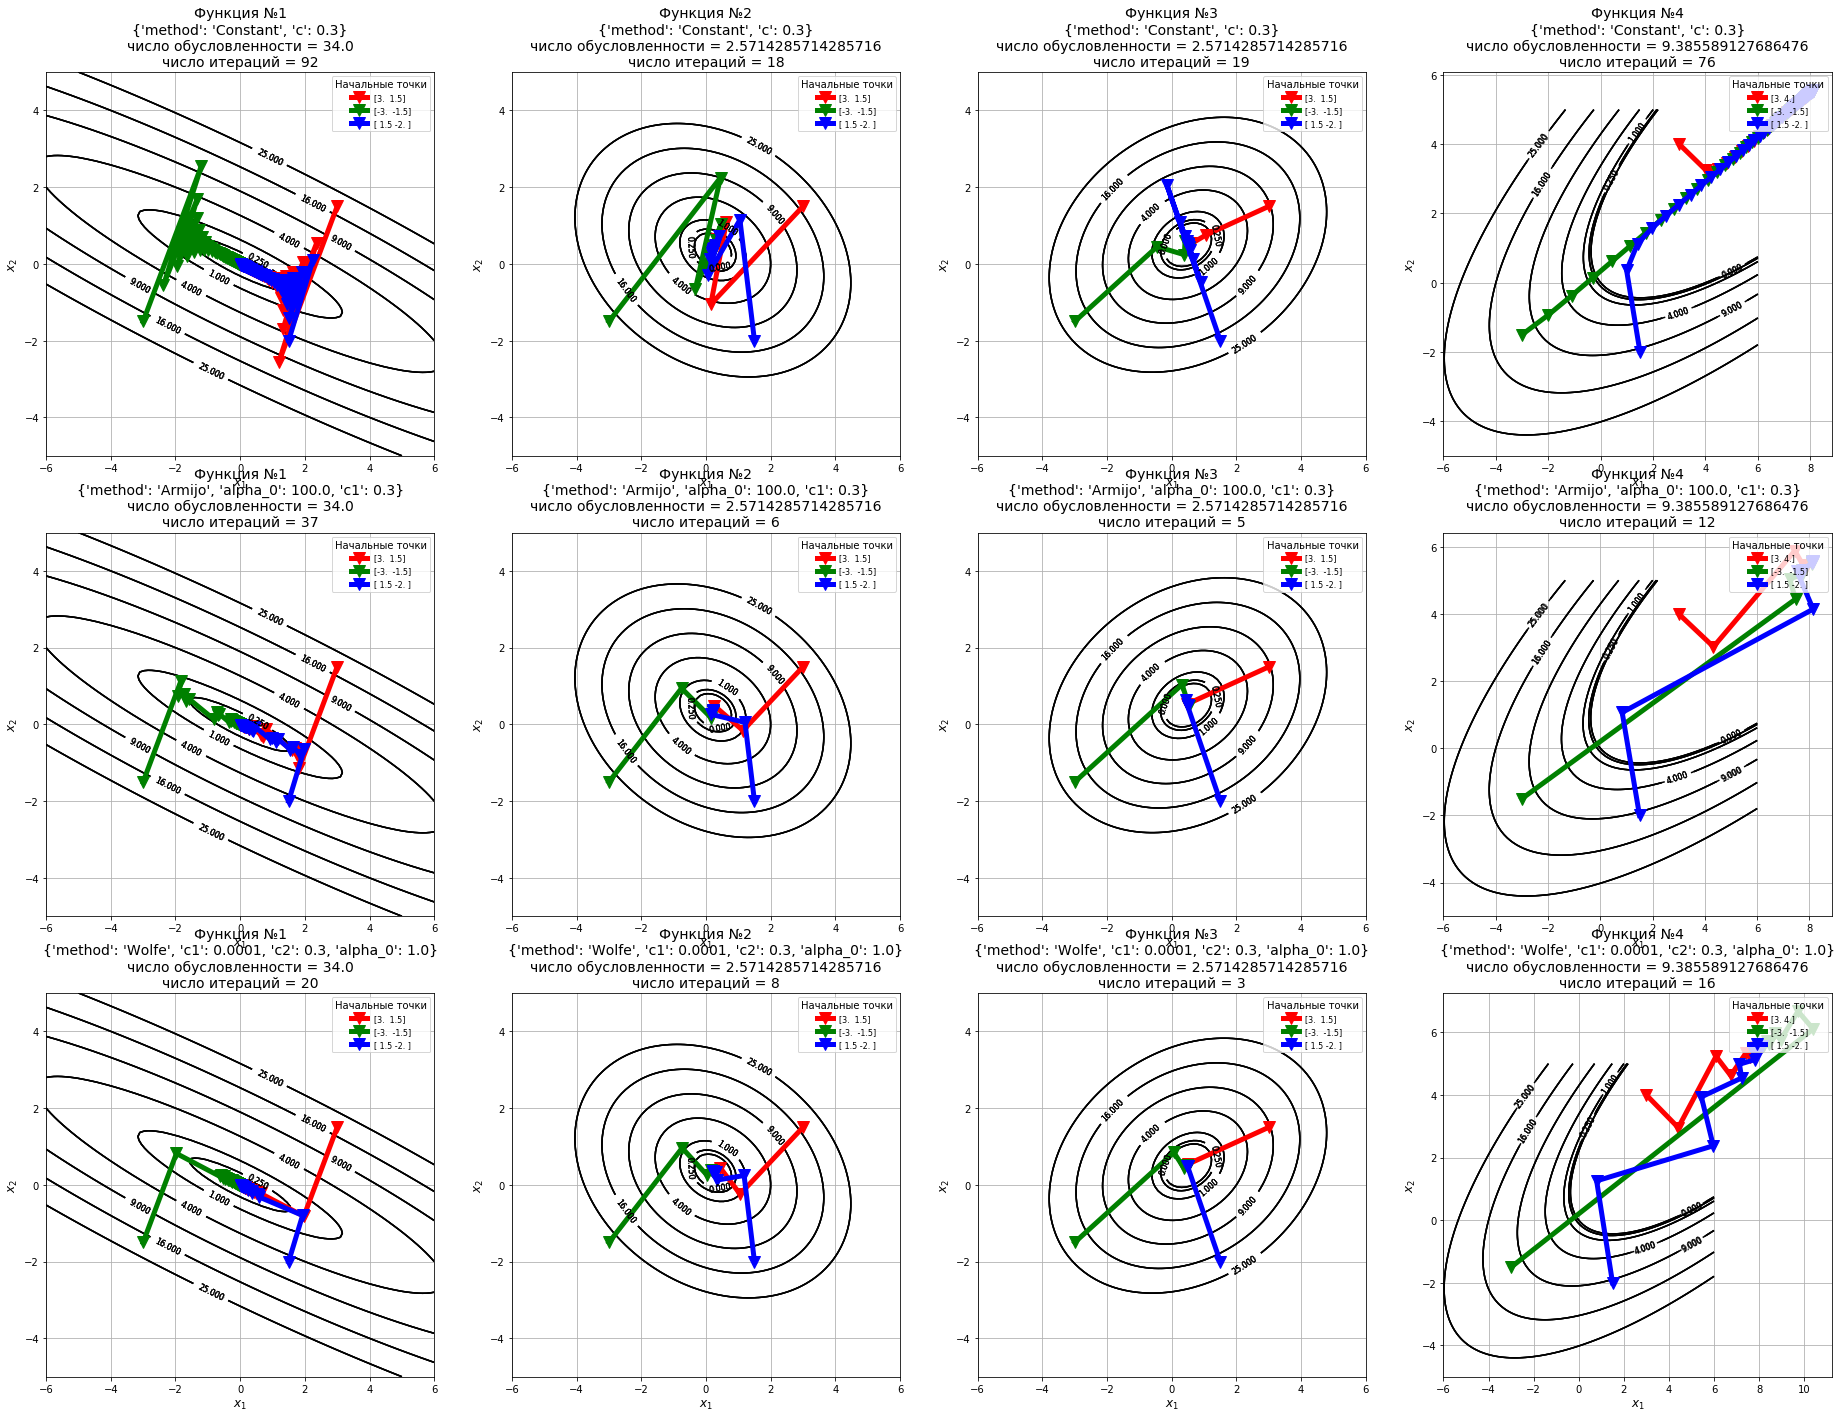

In [30]:
q_funcs = [{'A': np.array([[1.0, 2.0], [2.0, 5.0]]), 
            'b': np.array([0.0, 0.0]), 
            'x0': [np.array([3.0, 1.5]), np.array([-3.0, -1.5]), np.array([1.5, -2.0])]
           }, 
           {'A': np.array([[3.0, 1.0], [1.0, 5.0]]), 
            'b': np.array([1.0, 2.0]), 
            'x0': [np.array([3.0, 1.5]), np.array([-3.0, -1.5]), np.array([1.5, -2.0])]
            },
          {'A': np.array([[3.0, -1.0], [-1.0, 5.0]]), 
           'b': np.array([1.0, 2.0]), 
           'x0': [np.array([3.0, 1.5]), np.array([-3.0, -1.5]), np.array([1.5, -2.0])]
          },
          {'A': np.array([[1.0, -1.1], [-1.1, 2.001]]), 
           'b': np.array([2.0, 2.2]), 
           'x0': [np.array([3.0, 4.0]), np.array([-3.0, -1.5]), np.array([1.5, -2.0])]
          }]


methods = [{'method': 'Constant', 'c': 0.3}, 
           {'method': 'Armijo', 'alpha_0': 100.0, 'c1': 0.3}, 
           {'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.3, 'alpha_0': 1.0}]

colors = ['r', 'g', 'b', 'y']

nrows = len(methods)
ncols = len(q_funcs)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows))

for j, q_func in enumerate(q_funcs):
    
    con_n = conditionality_number(q_func['A'])
    
    for i, method in enumerate(methods):
        
        axes[i, j].set_xlabel('$x_1$', fontsize = 12)
        axes[i, j].set_ylabel('$x_2$', fontsize = 12)
        oracle = oracles.QuadraticOracle(q_func['A'], q_func['b'])
        
        for k, x0 in enumerate(q_func['x0']): 
            
            [x_star, msg, history] = optimization.gradient_descent(oracle, x0, line_search_options=method, trace=True)

            axes[i, j].set_title('Функция №' + str(j+1) + '\n' +\
                           str(method) + '\nчисло обусловленности = ' +\
                           str(con_n) + '\nчисло итераций = ' + str(len(history['x'])),
                           fontsize = 14)
            
            plt2d.plot_levels(oracle.func, fig_ax = (fig, axes[i, j]))
            plt2d.plot_trajectory(func=oracle.func, 
                                  history=history['x'],
                                  c = colors[k],
                                  fig_ax = (fig, axes[i, j]),
                                  label=str(x0))

            axes[i, j].legend(title='Начальные точки', loc='upper right', fontsize = 8)

**Вывод:** 
- количество итераций в градиентном спуске: адаптивный шаг с условием Вульфа < адаптивный шаг с условием Армихо < постоянный шаг; 
- не имеет значение с какой точки начинать, все они сходятся к одному и тому же минимуму, меняется лишь число итераций (чем дальше от точки минимума, тем больше итераций);
- чем больше число обусловленности, тем больше зигзагов.

## Эксперимент: Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространств

Исследуем, как зависит число итераций, необходимое градиентному спуску для сходимости, от следующих двух параметров: 
1) числа обусловленности κ ≥ 1 оптимизируемой функции
2) размерности пространства n оптимизируемых переменных.

Для этого для заданных параметров $n$ и $k$ сгенерируем случайным образом квадратичную задачу размера $n$ с числом обусловленности $k$ и запустите на ней градиентный спуск с некоторой фиксированной требуемой точностью. Замерим число итераций $T(n, k)$, которое потребовалось сделать методу до сходимости (успешному выходу по критерию остановки).

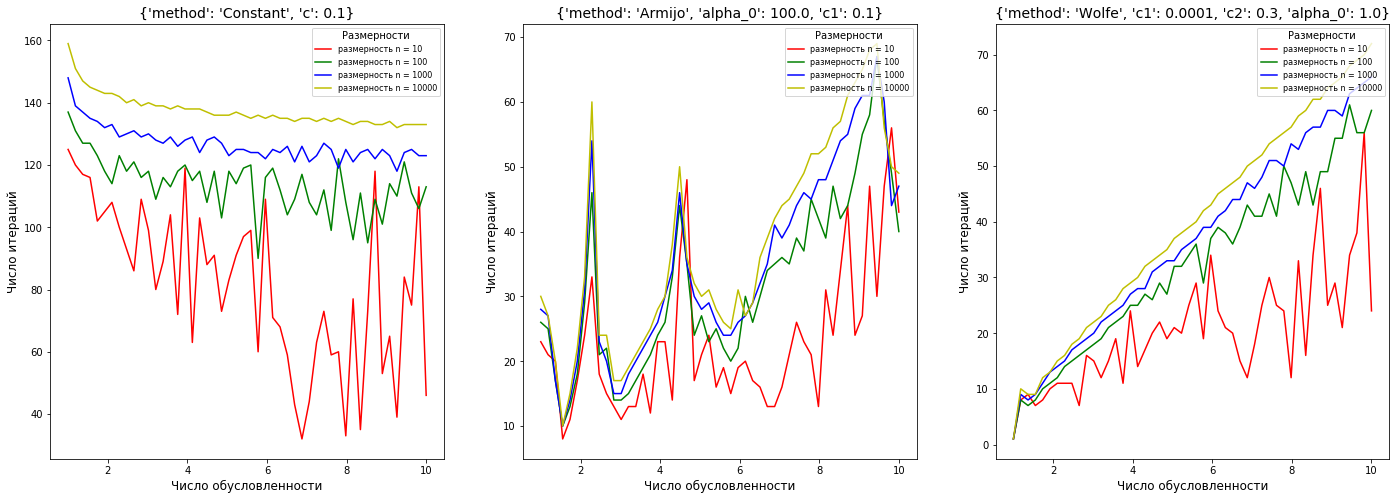

In [7]:
def generate_A(n, k):
    return scipy.sparse.diags(np.random.uniform(1, k, n))

def generate_b(n):
    return np.random.uniform(1, 1000, n)

methods = [{'method': 'Constant', 'c': 0.1}, 
           {'method': 'Armijo', 'alpha_0': 100.0, 'c1': 0.1}, 
           {'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.3, 'alpha_0': 1.0}]
colors = ['r', 'g', 'b', 'y']
d = {}
for n in [10, 100, 1000, 10000]:
    d[n] = {}
    for k in np.linspace(1, 10, 50):
        d[n][k] = (generate_A(n, k), generate_b(n))

ncols = len(methods)
fig, axes = plt.subplots(ncols=ncols, figsize=(8*ncols, 8))
        
for i, method in enumerate(methods):
    
    axes[i].set_xlabel('Число обусловленности', fontsize = 12)
    axes[i].set_ylabel('Число итераций', fontsize = 12)
    axes[i].set_title(str(method), fontsize = 14)
    
    for j, n in enumerate(d.keys()):
        x0 = np.ones(n)
        K = list(d[n].keys())
        I = []
        for k in K:
            oracle = oracles.QuadraticOracle(d[n][k][0], d[n][k][1])
            [x_star, msg, history, iters] = optimization.gradient_descent(oracle, x0, line_search_options=method)
            I.append(iters)
        axes[i].plot(K, I, c=colors[j], linestyle = '-', label='размерность n = {}'.format(n))
        axes[i].legend(title='Размерности', loc='upper right', fontsize = 8)

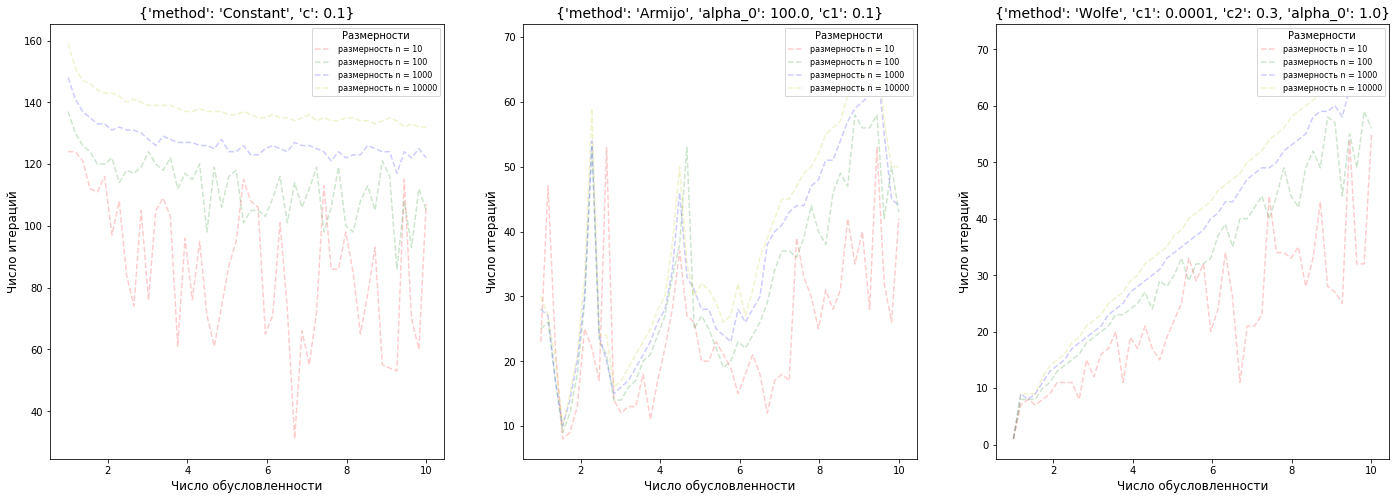

In [6]:
from collections import defaultdict

def generate_A(n, k):
    return scipy.sparse.diags(np.random.uniform(1, k, n))

def generate_b(n):
    return np.random.uniform(1, 1000, n)

methods = [{'method': 'Constant', 'c': 0.1}, 
           {'method': 'Armijo', 'alpha_0': 100.0, 'c1': 0.1}, 
           {'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.3, 'alpha_0': 1.0}]
colors = ['r', 'g', 'b', 'y']

ncols = len(methods)
fig, axes = plt.subplots(ncols=ncols, figsize=(8*ncols, 8))
       
for i, method in enumerate(methods):
    axes[i].set_xlabel('Число обусловленности', fontsize = 12)
    axes[i].set_ylabel('Число итераций', fontsize = 12)
    axes[i].set_title(str(method), fontsize = 14)    

for j, n in enumerate([10, 100, 1000, 10000]):
    x0 = np.ones(n)
    K = np.linspace(1, 10, 50)
    I_n = defaultdict(list)
    for k in K:
        oracle = oracles.QuadraticOracle(generate_A(n, k), generate_b(n))
        for i, method in enumerate(methods):
            _, _, _, iters = optimization.gradient_descent(oracle, x0, line_search_options=method)
            I_n[method['method']].append(iters)
    
    for i, method in enumerate(methods):
        axes[i].plot(K, I_n[method['method']], c=colors[j], linestyle = '-', label='размерность n = {}'.format(n), alpha=0.2)
        axes[i].legend(title='Размерности', loc='upper right', fontsize = 8)

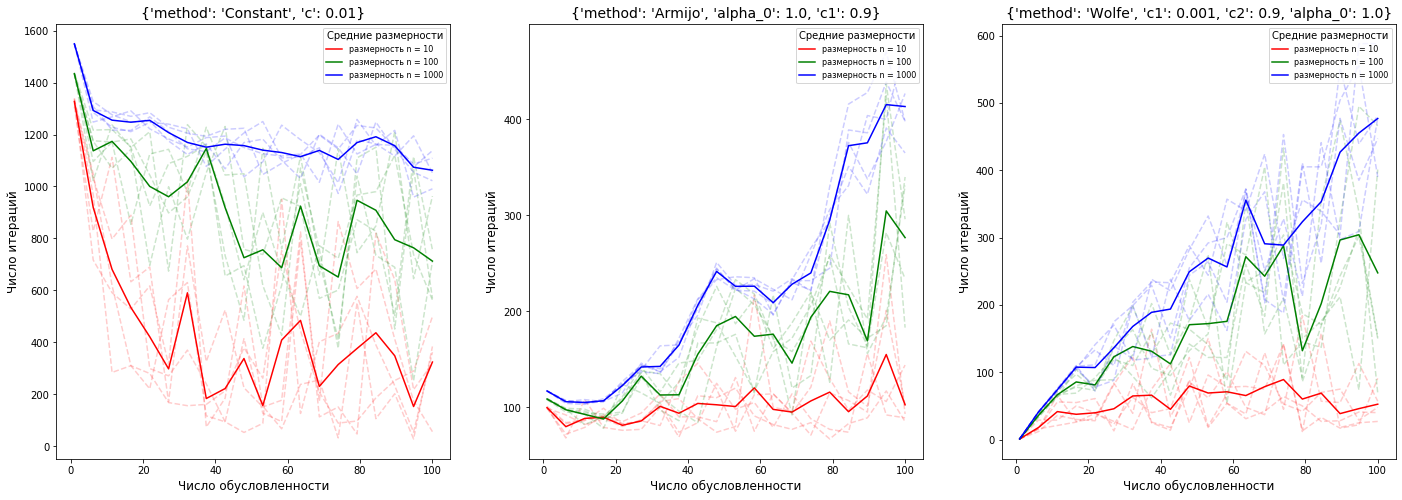

In [2]:
def generate_A(n, k):
    return scipy.sparse.diags(np.random.uniform(1, k, n))

def generate_b(n):
    return np.random.uniform(1, 1000, n)

methods = [{'method': 'Constant', 'c': 0.01}, 
           {'method': 'Armijo', 'alpha_0': 1.0, 'c1': 0.9}, 
           {'method': 'Wolfe', 'c1': 1e-3, 'c2': 0.9, 'alpha_0': 1.0}]
colors = ['r', 'g', 'b', 'y']

ncols = len(methods)
fig, axes = plt.subplots(ncols=ncols, figsize=(8*ncols, 8))
  
N = [10, 100, 1000]
K = np.linspace(1, 100, 20)
    
for i, method in enumerate(methods):
    
    axes[i].set_xlabel('Число обусловленности', fontsize = 12)
    axes[i].set_ylabel('Число итераций', fontsize = 12)
    axes[i].set_title(str(method), fontsize = 14)
    
    for j, n in enumerate(N):
        x0 = np.ones(n)
        I_sum = np.zeros(K.shape[0])
        for experiment in range(5):
            I = []
            for k in K:
                oracle = oracles.QuadraticOracle(generate_A(n, k), generate_b(n))
                [x_star, msg, history, iters] = optimization.gradient_descent(oracle, x0, line_search_options=method)
                I.append(iters)

            axes[i].plot(K, I, c=colors[j], linestyle = 'dashed', alpha=0.2)
            I_sum += I
        
        axes[i].plot(K, I_sum/5, c=colors[j], linestyle = '-', label='размерность n = {}'.format(n))
        axes[i].legend(title='Средние размерности', loc='upper right', fontsize = 8)

**Вывод:**

# Эксперимент: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

Сравним методы градиентного спуска и Ньютона на задаче обучения логистической регрессии на реальных данных.

В качестве реальных данных используем следующие три набора с сайта **LIBSVM3**: *w8a, gisette и real-sim*. Коэффициент регуляризации возьмем стандартным образом: $\lambda = \frac{1}{m}$.

Параметры обоих методов возьмем равными параметрам по умолчанию. Начальную точку выберем $x_0 = 0$.

Построим графики сходимости следующих двух видов:
(a) Зависимость значения функции от реального времени работы метода.
(b) Зависимость относительного квадрата нормы градиента $\frac{{\lVert \nabla f(x_k) \rVert}_{2}^{2}}{{\lVert \nabla f(x_0) \rVert}_{2}^{2}}$ (в логарифмической шкале) против реального времени работы.

При этом оба метода (градиентный спуск и Ньютон) нарисуем на одном и том же графике.

In [10]:
def compare_speed(svm_file, fig_axes=None):
    
    # Загрузка данных
    
    A, b = load_svmlight_file(svm_file)
    A, _, b, _ = train_test_split(A, b, test_size=0.7)
    m, n = A.shape[0], A.shape[1]
    regcoef = 1 / m
    oracle = oracles.create_log_reg_oracle(A, b, regcoef)
    _, _, history_gd, _ = optimization.gradient_descent(oracle, np.zeros(n), trace=True)
    _, _, history_n, _ = optimization.newton(oracle, np.zeros(n), display=True, trace=True)
    grad = oracle.grad(np.zeros(n))
    grad_norm_in_zero_point = grad.dot(grad)
    if fig_axes is None:
        fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
    else:
        fig, axes = fig_axes[0], fig_axes[1]
    
    # Первый график
    
    axes[0].set_title(svm_file)
    axes[0].set_xlabel('Время, с')
    axes[0].set_ylabel('Значение')
    axes[0].plot(history_gd['time'], history_gd['func'], label="Градиентный спуск")
    axes[0].plot(history_n['time'], history_n['func'], label="Метод Ньютона")
    axes[0].legend()

    # Второй график

    axes[1].set_title(svm_file)
    axes[1].plot(history_gd['time'], 
                 np.array(history_gd['grad_norm'])**2 / grad_norm_in_zero_point, 
                 label="Градиентный спуск")
    axes[1].plot(history_n['time'], 
                 np.array(history_n['grad_norm'])**2 / grad_norm_in_zero_point, 
                 label="Метод Ньютона")
    axes[1].set_yscale('log')
    axes[1].set_xlabel('Время, с')
    axes[1].set_ylabel(r'$log  \| \nabla f(x_k) \|_2^2 / \| \nabla f(x_0) \|_2^2$')
    axes[1].legend()

All OK!
All OK!


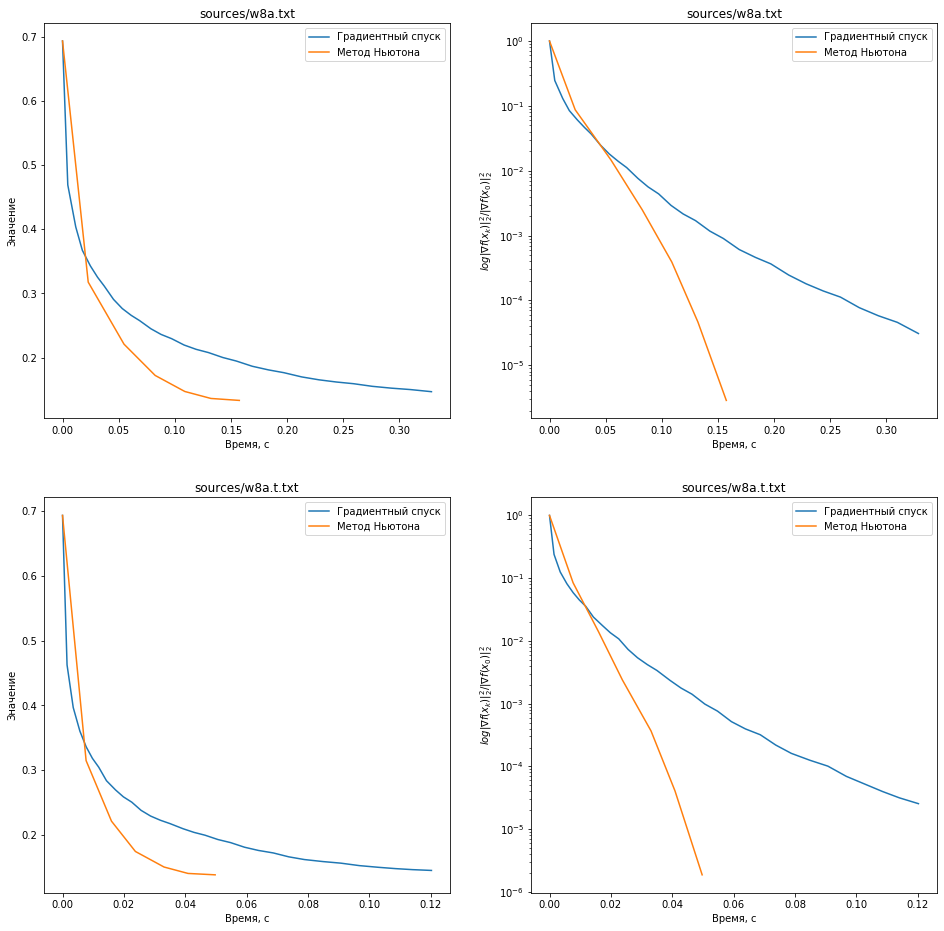

In [14]:
sources = ['sources/w8a.txt', 'sources/w8a.t.txt']

# 'sources/gisette_scale.bz2', 'sources/gisette_scale.t.bz2', 'sources/real-sim.bz2'

nrows = len(sources)
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 8*nrows))

for i, svm_file in enumerate(sources):
    compare_speed(svm_file, fig_axes=(fig, axes[i, :]))
    
fig.savefig('results.png')

**Вывод:**